In [1]:
# import package
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

In [2]:
# remove outliers
def valid(x, y, index):
    if y <= 2 or y > 100:
        return False
    for i in range(9):
        if x[len(index) - 1, i] <= 2 or x[len(index) - 1, i] > 100:
            return False
    return True

In [3]:
# Split the original data into x_train, y_train.
def parse2train(data, index):
    x, y = [], []

    total_length = data.shape[1] - 9
    for i in range(total_length):
        x_tmp = data[index, i:i + 9]
        y_tmp = data[17, i + 9]
        # filter
        if valid(x_tmp, y_tmp, index):
            x.append(x_tmp.reshape(-1, ))
            y.append(y_tmp)
    x, y = np.array(x), np.array(y)
    return x, y

In [4]:
# Split the original data into x_test, y_test.
def parse2test(data, index):
    x, y = [], []

    for i in range(857):
        x_tmp = data[index, 9 * i: 9 * i + 9]
        x.append(x_tmp.reshape(-1, ))
        try:
            y_tmp = data[17, 9 * i + 9]
        except IndexError:
            y_tmp = data[17, 7712]
        y.append(y_tmp)
    # x 會是一個(n, 18, 9)的陣列， y 則是(n, 1)
    x, y = np.array(x), np.array(y)
    return x, y

In [5]:
# calculate RMSE
def RMSE(pred: np.ndarray, real: np.ndarray) -> float:
    return np.sqrt(np.square(pred - real).mean())

In [6]:
# use Adam to train the model.
# https://keras.io/zh/optimizers/
def Adam(x, y, epochs):
    indexs = np.arange(x.shape[0])
    np.random.shuffle(indexs)
    x = x[indexs]
    y = y[indexs]

    epsilon = 1e-6
    lr = 0.001

    # dimension
    dim = x.shape[1]

    Lambda = np.array([[17500]] * dim)
    beta_1 = np.array([[0.995]] * dim)
    beta_2 = np.array([[0.999]] * dim)

    # init weight
    w = np.zeros(shape=(dim, 1))
    m = np.zeros(shape=(dim, 1))
    v = np.zeros(shape=(dim, 1))

    w_total = []

    t = 0
    for i in range(epochs):
        t += 1
        loss = y - np.dot(x, w)

        # l1 Regularization
        l1 = Lambda * np.sum(np.abs(w))

        # l2 Regularization
        l2 = Lambda * np.sum(np.square(w))

        g = (-2) * np.dot(x.T, loss) + l1 + l2

        m = beta_1 * m + (1 - beta_1) * g
        v = beta_2 * v + (1 - beta_2) * np.square(g)

        m_hat = m / (1 - (beta_1 ** t))
        v_hat = v / (1 - (beta_2 ** t))

        w = w - (lr * m_hat) / (np.sqrt(v_hat) + epsilon)
        
        # Record the weight of each training to test the best solution for the test data.
        w_total.append(w)

    return w_total

In [7]:
# Read training data.
train_data = pd.read_csv('train.csv')

# 把有些數字後面的奇怪符號刪除
for col in list(train_data.columns[2:]):
    train_data[col] = train_data[col].astype(str).map(lambda x: x.rstrip('x*#A'))

train_data = train_data.values.astype(np.float64).T

In [8]:
train_data_std = np.std(train_data, axis=1)

In [9]:
train_data_std

array([  4.69675834,   0.19062838,   0.1966181 ,   0.51993244,
         6.98743363,  10.90301757,  12.17922798,  21.1563903 ,
       109.26791579,   2.23638201,  11.46494592,   5.35356214,
         0.5324092 , 122.50354618, 122.21201063,   0.95785916,
         1.98734593, 120.88259088])

In [10]:
np.where(train_data_std > 10)

(array([ 5,  6,  7,  8, 10, 13, 14, 17], dtype=int64),)

In [11]:
# for std > 10
feature_index = [5, 6, 7, 8, 10, 13, 14, 17]

In [12]:
# Pre-processing of training datasets.
X_train, Y_train = parse2train(train_data, feature_index)

X_train = np.concatenate([X_train, np.ones(shape=(X_train.shape[0], 1))], axis=1)
Y_train = np.reshape(Y_train, (-1, 1))

In [13]:
# train the model.
w_total = Adam(X_train, Y_train, epochs=5000)

In [14]:
# Read test data.
test_data = pd.read_csv('test.csv')

test_data = test_data.values.astype(np.float64).T

# Pre-processing of test datasets.
X_test, Y_test = parse2test(test_data, feature_index)

X_test = np.concatenate([X_test, np.ones(shape=(X_test.shape[0], 1))], axis=1)
Y_test = np.reshape(Y_test, (-1, 1))

In [15]:
# Find the best weights to use on the test datasets.
# Preventing over-fitting.
rmse_min = 100
rmse_total = []
t = 0
for w in w_total:
    t += 1
    Y_pred = X_test.dot(w)

    rmse = RMSE(Y_pred, Y_test)

    rmse_total.append(rmse)

    if rmse < rmse_min:
        epoch = t
        rmse_min = rmse

In [16]:
# print which epoch is the best rmse.
print(epoch, rmse_min)

2210 6.503841361062664


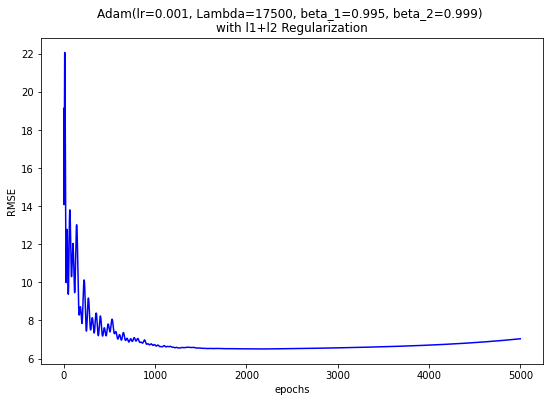

In [17]:
x = np.arange(5000)
plt.figure(figsize=(9, 6))
plt.plot(x, rmse_total, 'b')
plt.title('Adam(lr=0.001, Lambda=17500, beta_1=0.995, beta_2=0.999) \nwith l1+l2 Regularization')
plt.xlabel('epochs')
plt.ylabel('RMSE')
plt.show()

In [18]:
# save best weight.
np.save("best_w.npy", w_total[epoch])

In [19]:
# Export the best prediction results to my_sol.csv.

# load best weight.
best_w = np.load("best_w.npy")

with open('my_sol.csv', 'w', newline='') as csvf:
    writer = csv.writer(csvf)
    writer.writerow(['Id', 'Predicted'])
    Y_pred = X_test.dot(best_w)
    for i in range(int(X_test.shape[0])):
        writer.writerow([i + 1, float(Y_pred[i])])